In [1]:
import numpy as np
from numpy import kron
import math
from math import sqrt
from random import random

from scipy.optimize import linprog

import matplotlib.pyplot as plt
import matplotlib as mpl

from itertools import product

from matplotlib import colors

import time

from tqdm import tqdm

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def new_index(x):   # 012345 --> 123450
    b  = bin(x)[2:].zfill(6) # x in binary b0..b5
    y = int(b[1:]+b[0], 2)
    return y

def change_qbit_order(x): # 012345 --> 123450
    x_ordered = np.zeros_like(x)
    for i in range(64):
        for j in range(64):
            x_ordered[new_index(i), new_index(j)] = x[i,j]
    return x_ordered


def PP(w,z,u,v,V,lambda_0,lambda_1):
    
    ## settign states
    state_0 = np.array([1,0])
    state_1 = np.array([0,1])
    
    state_00 = kron(state_0,state_0).reshape(4,1)
    state_01 = kron(state_0,state_1).reshape(4,1)
    state_10 = kron(state_1,state_0).reshape(4,1)
    state_11 = kron(state_1,state_1).reshape(4,1)
    
    psi = (lambda_0*state_01 + lambda_1*state_10)
    
    
    rho_noiseless = np.dot(psi, psi.T)
    
    
    rho = V*rho_noiseless + ((1-V)/4)*np.identity(4)
    
    total_rho = kron(kron(rho,rho),rho)
    
    
    total_rho_ordered = change_qbit_order(total_rho)

    
    # Setting Measurment 
    out_00 = z*state_00 + w*state_11
    out_01 = w*state_00 - z*state_11
    out_10 = u*state_01 + v*state_10
    out_11 = v*state_01 - u*state_10
    
    M_state = np.array([[out_00, out_01],[out_10, out_11]])
    
    ## Resulting distribution
    
    p = np.zeros((2,2,2,2,2,2))

    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
    
        total_M_state = kron(kron(M_state[a1,a2], M_state[b1,b2]), M_state[c1,c2])
        E = np.dot(total_M_state, total_M_state.T)
        p[a1,a2,b1,b2,c1,c2] = np.trace(np.dot(E, total_rho_ordered))

    return p

# find epsilon...... it only depens on  V !!!

#%%
import sys
import mosek
import scipy.sparse as sp
# Since the value of infinity is ignored, we define it solely
# for symbolic purposes
inf = 1.0

# Define a stream printer to grab output from MOSEK
def streamprinter(text):
    sys.stdout.write(text)
    sys.stdout.flush()
    
def main_for_LP(c, A_eq, b_eq, A_ub ,b_ub, verbose=False):
    # Create a task object
    A = np.vstack((A_eq,A_ub))
    A = sp.coo_matrix(A)
    
    with mosek.Env() as env:
        with env.Task(0, 0) as task:
            # Attach a log stream printer to the task
            if verbose:
                task.set_Stream(mosek.streamtype.log, streamprinter)
    
            # Bound keys for constraints
            bkc = [mosek.boundkey.fx for i in range(len(A_eq))]+[mosek.boundkey.ra for i in range(len(A_ub))]
    
            # Bound values for constraints
            buc = list(b_eq)+list(b_ub)
            blc = list(b_eq)+[-inf for i in range(len(buc))]
            
            # Bound keys for variables
            bkx = [mosek.boundkey.ra for i in range(len(c))]
    
            # Bound values for variables
            blx = [0.0 for i in range(len(c))]
            bux = [1.0 for i in range(len(c))]
    
            numvar = len(bkx)
            numcon = len(bkc)

            # Append 'numcon' empty constraints.
            # The constraints will initially have no bounds.
            task.appendcons(numcon)
    
            # Append 'numvar' variables.
            # The variables will initially be fixed at zero (x=0).
            task.appendvars(numvar)
    
            for j in range(numvar):
                # Set the linear term c_j in the objective.
                task.putcj(j, c[j])
    
                # Set the bounds on variable j
                # blx[j] <= x_j <= bux[j]
                task.putvarbound(j, bkx[j], blx[j], bux[j])
    
                # Input column j of A
            task.putaijlist(list(A.row),list(A.col),list(A.data))          
    
            # Set the bounds on constraints.
             # blc[i] <= constraint_i <= buc[i]
            for i in range(numcon):
                task.putconbound(i, bkc[i], blc[i], buc[i])
    
            # Input the objective sense (minimize/maximize)
            task.putobjsense(mosek.objsense.minimize)
    
            # Solve the problem
            task.optimize()
            # Print a summary containing information
            # about the solution for debugging purposes
            if verbose:
                task.solutionsummary(mosek.streamtype.msg)
    
            # Get status information about the solution
            solsta = task.getsolsta(mosek.soltype.bas)
    
            #if (solsta == mosek.solsta.optimal):
            #xx = [0.0] * numvar
            #task.getxx(mosek.soltype.itr, xx)
                #print("Optimal solution: ")
                #for i in range(numvar):
                #    print("x[" + str(i) + "]=" + str(xx[i]))
            #elif (solsta == mosek.solsta.dual_infeas_cer or
            #      solsta == mosek.solsta.prim_infeas_cer):
            #    if verbose:
            #        print("Primal or dual infeasibility certificate found.\n")
            #elif solsta == mosek.solsta.unknown:
            #    print("Unknown solution status")
            #else:
            #    print("Other solution status")
            #obje = task.getprimalobj(mosek.soltype.itr)
            #if verbose:
            #    print(obje)
            return solsta
        

In [3]:
def main_for_LP_noise_less(c, A_eq, b_eq, verbose=False):
    # Create a task object

    A = sp.coo_matrix(A_eq)
    
    with mosek.Env() as env:
        with env.Task(0, 0) as task:
            # Attach a log stream printer to the task
            if verbose:
                task.set_Stream(mosek.streamtype.log, streamprinter)
    
            # Bound keys for constraints
            bkc = [mosek.boundkey.fx for i in range(len(A_eq))]
    
            # Bound values for constraints
            buc = list(b_eq)
            blc = list(b_eq)
            
            # Bound keys for variables
            bkx = [mosek.boundkey.ra for i in range(len(c))]
    
            # Bound values for variables
            blx = [0.0 for i in range(len(c))]
            bux = [1.0 for i in range(len(c))]
    
            numvar = len(bkx)
            numcon = len(bkc)

            # Append 'numcon' empty constraints.
            # The constraints will initially have no bounds.
            task.appendcons(numcon)
    
            # Append 'numvar' variables.
            # The variables will initially be fixed at zero (x=0).
            task.appendvars(numvar)
    
            for j in range(numvar):
                # Set the linear term c_j in the objective.
                task.putcj(j, c[j])
    
                # Set the bounds on variable j
                # blx[j] <= x_j <= bux[j]
                task.putvarbound(j, bkx[j], blx[j], bux[j])
    
                # Input column j of A
            task.putaijlist(list(A.row),list(A.col),list(A.data))          
    
            # Set the bounds on constraints.
             # blc[i] <= constraint_i <= buc[i]
            for i in range(numcon):
                task.putconbound(i, bkc[i], blc[i], buc[i])
    
            # Input the objective sense (minimize/maximize)
            task.putobjsense(mosek.objsense.minimize)
    
            # Solve the problem
            task.optimize()
            # Print a summary containing information
            # about the solution for debugging purposes
            if verbose:
                task.solutionsummary(mosek.streamtype.msg)
    
            # Get status information about the solution
            solsta = task.getsolsta(mosek.soltype.bas)
    
            #if (solsta == mosek.solsta.optimal):
            #xx = [0.0] * numvar
            #task.getxx(mosek.soltype.itr, xx)
                #print("Optimal solution: ")
                #for i in range(numvar):
                #    print("x[" + str(i) + "]=" + str(xx[i]))
            #elif (solsta == mosek.solsta.dual_infeas_cer or
            #      solsta == mosek.solsta.prim_infeas_cer):
            #    if verbose:
            #        print("Primal or dual infeasibility certificate found.\n")
            #elif solsta == mosek.solsta.unknown:
            #    print("Unknown solution status")
            #else:
            #    print("Other solution status")
            #obje = task.getprimalobj(mosek.soltype.itr)
            #if verbose:
            #    print(obje)
            return solsta


## Noiseless LP

In [6]:
def get_result_map_mosek_noise_less(l0, N_it_u, N_it_w):   #l0 --> lambda0 


    l1 = np.sqrt(1-l0**2)
    
    q = l0**2  #probability of sending token to right/left?

    q_a = [q, 1-q]
    q_b = [q, 1-q]
    q_c = [q, 1-q]

    c = np.ones(64) 


    # Form the matrix A

    #First we consider the probability constraints 

    A_1 = np.zeros((64,64))

    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
        constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
        for ta,tb,tc in product(range(2), repeat=3): 
            if (a1 == (tb+tc+1)%2) and (b1 == (ta+tc+1)%2) and (c1 == (ta+tb+1)%2): # ParityCheck
                var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
                A_1[constraint_it, var_it] = 1



    #Now we consider the network independence constraints

    A_3a = np.zeros((8,64))
    for a2,tb,tc in product(range(2),repeat=3):
        constraint_it = np.inner([4,2,1],[a2,tb,tc])
        for b2,c2 in product(range(2),repeat=2):
            var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,0,tb,tc]) # ta = 0
            var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,1,tb,tc]) # ta = 1
            A_3a[constraint_it, var_it_0] = q_a[1]/q_a[0]
            A_3a[constraint_it, var_it_1] = -1


    A_3b = np.zeros((8,64))
    for b2,ta,tc in product(range(2),repeat=3):
        constraint_it = np.inner([4,2,1],[b2,ta,tc])
        for a2,c2 in product(range(2),repeat=2):
            var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,0,tc])# tb = 0
            var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,1,tc])# tb = 1
            A_3b[constraint_it, var_it_0] = q_b[1]/q_b[0]
            A_3b[constraint_it, var_it_1] = -1


    A_3c = np.zeros((8,64))
    for c2,ta,tb in product(range(2),repeat=3):
        constraint_it = np.inner([4,2,1],[c2,ta,tb])
        for a2,b2 in product(range(2),repeat=2):
            var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,0])# tc = 0
            var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,1])# tc = 1
            A_3c[constraint_it, var_it_0] = q_c[1]/q_c[0]
            A_3c[constraint_it, var_it_1] = -1




    A = np.concatenate([A_1,A_3a,A_3b,A_3c])  

    #remove the redundant rows
    #_, inds = sympy.Matrix(A).T.rref()   # I transposed to check for the rows 
    #A = A[np.array(inds)]
    #print("Number of independent equations", A.shape[0])

    #print("Size of The LP system: ", A.shape)




    phi_u_list = np.linspace(0, np.pi/2, num = N_it_u)
    phi_w_list = np.linspace(0, np.pi/4, num = N_it_w) 

    result_map = np.zeros((N_it_u, N_it_w)) 
    
    for i in tqdm(range(N_it_u)):
        for j in range(N_it_w):
            tic1 = time.perf_counter()
            phi_u = phi_u_list[i]
            phi_w = phi_w_list[j]
            
            prob = PP(np.cos(phi_w), np.sin(phi_w), np.cos(phi_u), np.sin(phi_u),1,l0,l1) #V=1 No noise


            # Form the vector b            
            b_1 = np.zeros(64)
            for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
                constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
                b_1[constraint_it] = prob[a1,a2,b1,b2,c1,c2]

            b_3 = np.zeros(24)


            b = np.concatenate([b_1,b_3])
            #b = b[np.array(inds)] # remove the redundent


            res = main_for_LP_noise_less(c, A_eq=A, b_eq=b, verbose=False)  #???

            if res == mosek.solsta.prim_infeas_cer: #inside infeasible range
                result_map[i, j] = 1
                
    ## Add the other half side for w
    result_map_flip = np.flip(result_map, 1)
    result_map_final = np.concatenate((result_map, result_map_flip), axis=1)

                
    return result_map_final


In [7]:
def plot(result_map):
    fig, ax = plt.subplots(figsize=(7,7))
    # using ListedColormap method from the colors package we can define a color map
    colormap = colors.ListedColormap(["lightyellow","dodgerblue"])
    # handing this problem over to 
    plt.imshow(result_map,
                 cmap=colormap,  extent=[0,np.pi/2,0,np.pi/2], origin='lower')
    plt.xlabel("$\phi_1 \ [w=cos(\phi_1)]$",
                 size = 14)
    plt.ylabel("$\phi_2 \ [u=cos(\phi_2)]$",
                 size = 14)

    plt.show() 


In [8]:
def print_uw_nonlocal(result_map, N_it_u, N_it_w):

    phi_u_list = np.linspace(0, np.pi/2, num = N_it_u)
    phi_w_list = np.linspace(0, np.pi/2, num = N_it_w) 

    nl_indx_phi_u, nl_indx_phi_w = np.where(result_map==1)

    print("Nonlocality found setting for:")

    for i in range(len(nl_indx_phi_u)):
        print("phi_u: ", phi_u_list[nl_indx_phi_u[i]], "  phi_w: ",phi_w_list[nl_indx_phi_w[i]])



# Single experiment with TV distance $\epsilon$

In [ ]:
f_\epsilon

### The LP:

$$P_{PTC}^{main}(a_1,a_2,b_1,b_2,c_1,c_2) = P_{PTC}^{New}(a_1,a_2,b_1,b_2,c_1,c_2) + (f_\epsilon+\epsilon) ~ x(a_1,a_2,b_1,b_2,c_1,c_2) - (f_\epsilon+\epsilon) ~ y(a_1,a_2,b_1,b_2,c_1,c_2) \Rightarrow$$


$$\boxed{P_{PTC}^{main}(a_1,a_2,b_1,b_2,c_1,c_2) =\sum_{t_a, t_b, t_c \Rightarrow a_1, b_1, c_1}{P(a_2,b_2,c_2, t_a, t_b, t_c)} + (f_\epsilon+\epsilon) ~ x(a_1,a_2,b_1,b_2,c_1,c_2) - (f_\epsilon+\epsilon) ~ y(a_1,a_2,b_1,b_2,c_1,c_2)} $$


$$ \boxed{\sum x(a_1,a_2,b_1,b_2,c_1,c_2) = 1 = \sum y(a_1,a_2,b_1,b_2,c_1,c_2)}$$

for $\alpha = \frac{\epsilon}{(f_\epsilon+\epsilon)}$, we have:
$\delta_{TV}(x(a_2,b_2,c_2), y(a_2,b_2,c_2)) \leq \alpha  \Rightarrow x(a_2,b_2,c_2) =y(a_2,b_2,c_2)-\alpha y'(a_2,b_2,c_2) +\alpha x'(a_2,b_2,c_2) \Rightarrow $

$$\boxed{\sum_{a_1,b_1,c_1} x(a_1,a_2,b_1,b_2,c_1,c_2) -  \sum_{a_1,b_1,c_1} y(a_1,a_2,b_1,b_2,c_1,c_2) +\alpha y'(a_2,b_2,c_2) -\alpha x'(a_2,b_2,c_2)=0} $$

$$ \boxed{\sum x'(a_2,b_2,c_2) = 1 = \sum y'(a_2,b_2,c_2)}$$





and Network constraint:

$$P(a_2|0, t_b, t_c) = P(a_2|1, t_b, t_c) \Leftrightarrow q(t_a = 1) \sum_{b_2,c_2}  {P(a_2,b_2,c_2,0, t_b, t_c)} -  q(t_a = 0) \sum_{b_2,c_2}P(a_2,b_2,c_2,1, t_b, t_c) = 0$$


$|E_A^{main} - E_A^{New}| \leq 2(f_\epsilon+\epsilon)$:

$$ q_{low} = \frac{1}{2}(1+\sqrt{\frac{(E_A^{main}-2(f_\epsilon+\epsilon))(E_A^{main}-2(f_\epsilon+\epsilon))}{E_A^{main}+2(f_\epsilon+\epsilon)}}) \leq q(t_a = 1) = \frac{1}{2}(1+\sqrt{\frac{E_B E_C}{E_A}}) \leq \frac{1}{2}(1+\sqrt{\frac{(E_A^{main}+2(f_\epsilon+\epsilon))(E_A^{main}+2(f_\epsilon+\epsilon))}{E_A^{main}-2(f_\epsilon+\epsilon)}}) = q_{up}$$





Then we have: 



$$\boxed{ q_{low} \sum_{b_2,c_2}  {P(a_2,b_2,c_2,0, t_b, t_c)} - (1-q_{low}) \sum_{b_2,c_2}P(a_2,b_2,c_2,1, t_b, t_c) \leq 0 \leq q_{up} \sum_{b_2,c_2}  {P(a_2,b_2,c_2,0, t_b, t_c)} - (1-q_{up}) \sum_{b_2,c_2}P(a_2,b_2,c_2,1, t_b, t_c)}$$


In [9]:
# vars order are : P,x,y,x',y'

In [10]:
def f(eps):
    if eps<=1/4:
        f = 1/2 + eps - (1-4*eps)/(2*np.sqrt(1-2*eps))
    else:
        f=1/2+eps
    return f

In [18]:
def get_single_exp_mosek(l0, eps , phi_u, phi_w, honest_q=False, N_grid_q=1):   # W = 1-visibility
    
    #l0 = np.sqrt(1/3)  #lambda0
    l1 = np.sqrt(1-l0**2)
    

    q = l0**2  #probability of sending token to right/left?

    q_a = [q, 1-q]
    q_b = [q, 1-q]
    q_c = [q, 1-q]

    c = np.zeros(64*3+8*2)  # number of vars = 208 ....


    # Form the matrix A

    #First we consider the probability constraints 
    A_1 = np.zeros((64, 64*3+8*2))

    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
        constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
        for ta,tb,tc in product(range(2), repeat=3): 
            if (a1 == (tb+tc+1)%2) and (b1 == (ta+tc+1)%2) and (c1 == (ta+tb+1)%2): # ParityCheck
                var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
                A_1[constraint_it, var_it] = 1
        A_1[constraint_it, constraint_it+64] = f(eps)+eps  # ---> x coef
        A_1[constraint_it, constraint_it+(64*2)] = -(f(eps)+eps)  # ---> y coef


    #Normalization for x and y
    A_1_norm_xy = np.zeros((2, 64*3+8*2))    
    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
        temp = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
        A_1_norm_xy[0, temp+64] = 1 # ---> x coef
        A_1_norm_xy[1, temp+(64*2)] = 1 # ---> y coef

    # sum over a1,b1,c1 for x and y are 1/3 close in TV...
    A_x2y2 =  np.zeros((8, 64*3+8*2))
    for a2,b2,c2 in product(range(2), repeat=3):  
        constraint_it = np.inner([4,2,1],[a2,b2,c2]) 
        for a1,b1,c1 in product(range(2), repeat=3):
            temp = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
            A_x2y2[constraint_it, temp+64] = 1 # ---> x coef
            A_x2y2[constraint_it, temp+(64*2)] = -1  # ---> y coef
            
            if eps == 0:
                alpha = 0
            else:
                alpha = eps/(f(eps)+eps)
                
            A_x2y2[constraint_it, constraint_it+(64*3)] = -alpha # ---> x' coef
            A_x2y2[constraint_it, constraint_it+(64*3)+8] = alpha # ---> y' coef
            
            
    #Normalization for x' and y' 
    A_1_norm_xy_prime = np.zeros((2, 64*3+8*2))
    for a2,b2,c2 in product(range(2), repeat=3):
        temp = np.inner([4,2,1],[a2,b2,c2])
        A_1_norm_xy_prime[0, temp+(64*3)] = 1 # ---> x' coef
        A_1_norm_xy_prime[1, temp+(64*3)+8] = 1 # ---> y' coef
    


    A_eq = np.concatenate([A_1,A_1_norm_xy,A_x2y2,A_1_norm_xy_prime])
    
    
    #form part of b that doesnt depend on distribution
    b_1_normxy = np.ones(2)
    b_x2y2 = np.zeros(8)
    b_3_up = np.zeros(24)
    b_3_low = np.zeros(24)
    b_1_normxy_prime = np.ones(2)


    prob = PP(np.cos(phi_w), np.sin(phi_w), np.cos(phi_u), np.sin(phi_u),1,l0,l1) #V=1 No noise


    # Form the vector b            
    b_1 = np.zeros(64)
    for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
        constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
        b_1[constraint_it] = prob[a1,a2,b1,b2,c1,c2]



    b_eq = np.concatenate([b_1,b_1_normxy,b_x2y2,b_1_normxy_prime])

    b_up = np.concatenate([b_3_up, b_3_low])



    # Continue A
    # Now we consider the network independence constraints
    '''
    E_A_obs = 2*np.sum(prob[1,:,:,:,:,:])-1
    q_up  = 0.5*(1+np.sqrt(E_A_obs+4*eps))   #q_a[1] 
    q_low = 0.5*(1+np.sqrt(E_A_obs-4*eps))   #q_a[1]
    '''

    if honest_q == False:
        
        delta = f(eps)+eps

        E_A_obs_ptc = np.abs(2*(np.sum(prob[0,:,0,:,1,:]) + np.sum(prob[0,:,1,:,0,:]) )-1) #for q_a(0) inside ptc

        q_up_main  = 0.5*(1+((E_A_obs_ptc + 2*delta)/np.sqrt(E_A_obs_ptc - 2*delta)))
        q_up_main  = min(1, q_up_main)

        q_low_main = 0.5*(1+((E_A_obs_ptc - 2*delta)/np.sqrt(E_A_obs_ptc + 2*delta)))
        q_low_main = max(0,q_low_main)

    else:
        q_up_main  = q_a[1]
        q_low_main = q_a[1]


    # Doing the grid search.............

    #N_grid_q => number of subintervals

    q_bounds = np.linspace(q_low_main, q_up_main, N_grid_q+1)

    feasible_q_founded = False

    #for k_a, k_b, k_c in product(range(N_grid_q), repeat=3):
    for k_a in range(N_grid_q):
        for k_b in range(k_a+1):
            for k_c in range(k_b+1):

                q_low_a = q_bounds[k_a]
                q_up_a = q_bounds[k_a+1]

                q_low_b = q_bounds[k_b]
                q_up_b = q_bounds[k_b+1]

                q_low_c = q_bounds[k_c]
                q_up_c = q_bounds[k_c+1]


                # upper bound...... and lower bound ...............
                A_3a_up = np.zeros((8,64*3+8*2))
                A_3a_low = np.zeros((8,64*3+8*2))

                for a2,tb,tc in product(range(2),repeat=3):
                    constraint_it = np.inner([4,2,1],[a2,tb,tc])
                    for b2,c2 in product(range(2),repeat=2):
                        var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,0,tb,tc]) # ta = 0
                        var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,1,tb,tc]) # ta = 1
                        A_3a_up[constraint_it, var_it_0] = -q_up_a
                        A_3a_up[constraint_it, var_it_1] = (1-q_up_a)

                        A_3a_low[constraint_it, var_it_0] = q_low_a
                        A_3a_low[constraint_it, var_it_1] = -(1-q_low_a)


                A_3b_up = np.zeros((8,64*3+8*2))
                A_3b_low = np.zeros((8,64*3+8*2))
                for b2,ta,tc in product(range(2),repeat=3):
                    constraint_it = np.inner([4,2,1],[b2,ta,tc])
                    for a2,c2 in product(range(2),repeat=2):
                        var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,0,tc])# tb = 0
                        var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,1,tc])# tb = 1
                        A_3b_up[constraint_it, var_it_0] = -q_up_b
                        A_3b_up[constraint_it, var_it_1] = (1-q_up_b)

                        A_3b_low[constraint_it, var_it_0] = q_low_b
                        A_3b_low[constraint_it, var_it_1] = -(1-q_low_b)


                A_3c_up = np.zeros((8,64*3+8*2))
                A_3c_low = np.zeros((8,64*3+8*2))

                for c2,ta,tb in product(range(2),repeat=3):
                    constraint_it = np.inner([4,2,1],[c2,ta,tb])
                    for a2,b2 in product(range(2),repeat=2):
                        var_it_0 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,0])# tc = 0
                        var_it_1 = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,1])# tc = 1
                        A_3c_up[constraint_it, var_it_0] = -q_up_c
                        A_3c_up[constraint_it, var_it_1] = (1-q_up_c)

                        A_3c_low[constraint_it, var_it_0] = q_low_c
                        A_3c_low[constraint_it, var_it_1] = -(1-q_low_c)




                A_up = np.concatenate([A_3a_up,A_3b_up,A_3c_up, A_3a_low,A_3b_low,A_3c_low]) 


                res = main_for_LP(c, A_eq, b_eq, A_up ,b_up,verbose=False)  

                if res != mosek.solsta.prim_infeas_cer: #if feasible for some qs in the grid
                    feasible_q_founded = True
                    break


    return (feasible_q_founded)*1 #output 1 if feasible!

## Make the Plot Noise

In [21]:
def Noise_Plot_Get_Data(l0, eps_list, grid_size, honest_q=False, N_grid_q=1):

    tic = time.perf_counter()


    N_it = grid_size


    noise_map = np.zeros((N_it, N_it//2))


    phi_u_list = np.linspace(0, np.pi/2, num = N_it)
    phi_w_list = np.linspace(0, np.pi/4, num = N_it//2)   # we have mirror symemtry for w .......


    for i in tqdm(range(N_it)):
        for j in range(N_it//2):

        
            phi_u = phi_u_list[i]
            phi_w = phi_w_list[j]

            eps_max = 0
            for eps in eps_list:
                feasiblity_flag = get_single_exp_mosek(l0, eps, phi_u, phi_w, honest_q, N_grid_q)
                if feasiblity_flag:
                    break
                eps_max = eps  # saves the last infeasible eps
            noise_map[i,j] = eps_max

    ## Add the other half side for phi_w
    noise_map_flip = np.flip(noise_map, 1)
    noise_map_final = np.concatenate((noise_map, noise_map_flip), axis=1)



    toc = time.perf_counter()
    print("time: ", np.round((toc-tic)/60, 2), " mins")


    return noise_map_final




################### FULL PLOT ##############################
    
    
def Noise_Plot_Show(noise_map_final):

    total_map =  noise_map_final #- 0.004*(local_map)

    total_map = total_map *100 # in %

    fig, ax = plt.subplots(figsize=(8,8))

    ax.set_title("Noise map for TV")
    plt.imshow(total_map ,origin='lower', extent=[0,np.pi/2,0,np.pi/2])

    # Add colorbar
    
    # Add colorbar
    num_colors=len(np.unique(noise_map_final))
    #step = np.min(total_map[np.nonzero(noise_map_final)])
    #plt.colorbar(boundaries=np.linspace(0, np.max(total_map)+step, num_colors+1)) # + step foor interval of bouns
    plt.colorbar(boundaries=np.linspace(0, np.max(total_map), num_colors))

    plt.xlabel("$\phi_1 \ [w=cos(\phi_1)]$", size = 14)
    plt.ylabel("$\phi_2 \ [u=cos(\phi_2)]$", size = 14)

    plt.show() 

## Honest tokens

In [24]:
l0 = np.sqrt(0.22)
eps_list = np.linspace(0, 0.004, 50) 
grid_size = 50

noise_map_final = Noise_Plot_Get_Data(l0, eps_list, grid_size, honest_q=True, N_grid_q=1)

100%|███████████████████████████████████████████| 50/50 [04:03<00:00,  4.86s/it]

time:  4.05  mins


In [33]:
np.max(noise_map_final)

0.0024489795918367346

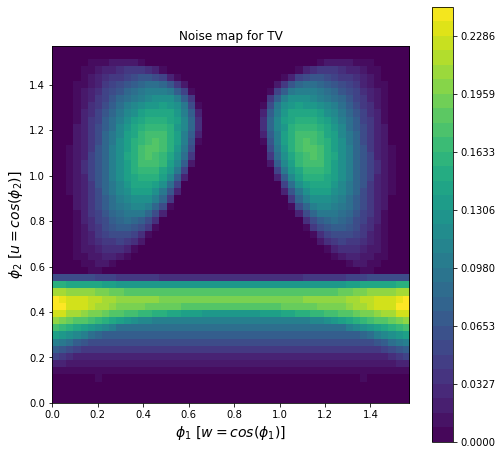

In [27]:
Noise_Plot_Show( noise_map_final)

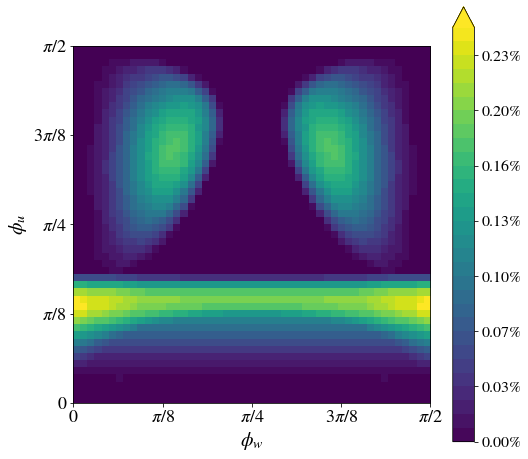

In [32]:
Noise_Plot_Show_new(noise_map_final)

In [59]:
np.linspace(0, 0.003, 31) 

array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029, 0.003 ])

In [63]:
np.max(noise_map_final)

0.0014

## Noisy distribution 

In [34]:
np.linspace(0, 0.0025, 25+1)

array([0.    , 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
       0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025])

# Run over night

100%|██████████████████████████████████████| 50/50 [20:46:09<00:00, 1495.38s/it]


time:  1246.15  mins


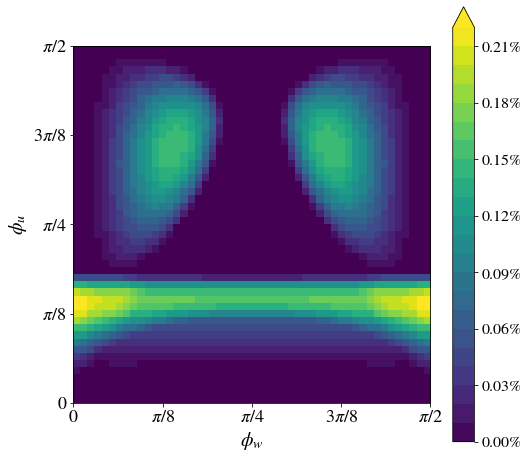

In [35]:
l0 = np.sqrt(0.22)

eps_list = np.linspace(0, 0.0025, 25+1)
grid_size = 50
honest_q=FalseNX
N_grid_q = 16

noise_map_final = Noise_Plot_Get_Data(l0, eps_list, grid_size, honest_q, N_grid_q)
np.savez('TV_noise_22_q16_50.npz', noise_map_final=noise_map_final)
Noise_Plot_Show_new(noise_map_final)

[0.     0.0001 0.0002 0.0003 0.0004 0.0005 0.0006 0.0007 0.0008 0.0009
 0.001  0.0011 0.0012 0.0013 0.0014 0.0015 0.0016 0.0017 0.0018 0.0019
 0.002  0.0021 0.0022 0.0023]


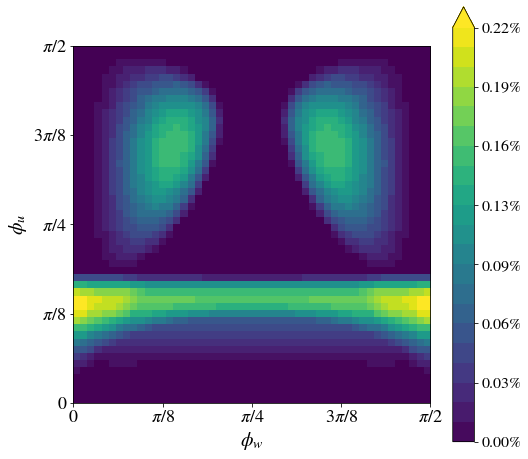

In [73]:
Noise_Plot_Show_new(noise_map_final)

In [36]:
np.max(noise_map_final)

0.0022

In [87]:
from numpy import unravel_index

phi_u_list = np.linspace(0, np.pi/2, num = 50)
phi_w_list = np.linspace(0, np.pi/2, num = 50)


i_max, j_max = unravel_index(noise_map_final.argmax(), noise_map_final.shape)
phi_u_max = phi_u_list[i_max]
phi_w_max = phi_w_list[j_max]

print("Max noise is ", np.max(noise_map_final), "for:")
print("$phi_w$", phi_w_max)
print("$phi_u$", phi_u_max)

Max noise is  0.0024000000000000002 for:
$phi_w$ 0.0
$phi_u$ 0.41674188261905415


In [81]:
np.max(noise_map_final)

0.0024000000000000002

In [ ]:
data = np.load('TV_noise_225_q10_50.npz')
noise_map_final = data['noise_map_final']
local_map = data['local_map']

Noise_Plot_Show(local_map, noise_map_final)

In [72]:
import matplotlib
import matplotlib.ticker as mtick

def Noise_Plot_Show_new(noise_map_final):
    
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    
    matplotlib.rcParams['axes.titlepad'] = 10  # pad is in points...
    

    total_map =   noise_map_final #-0.004*(local_map)


    fig, ax = plt.subplots(figsize=(8,8))

    #ax.set_title("TV Distance Map", size = 20)
    
    plt.imshow(total_map ,origin='lower', extent=[0,np.pi/2,0,np.pi/2])


    
    # Add colorbar
    num_colors=len(np.unique(noise_map_final))
    step = np.min(total_map[np.nonzero(noise_map_final)])
    print(np.linspace(0, np.max(total_map)+step, num_colors+1))
    
    cbar = plt.colorbar(extend="max", boundaries=np.linspace(0, np.max(total_map), 22)) # + step foor interval of bouns
    #cbar = plt.colorbar(extend="max", boundaries=np.linspace(0, np.max(total_map), num_colors))

    
    cbar.ax.tick_params(labelsize=16)

    # Format the colorbar to display percentages
    formatter = mtick.FuncFormatter(lambda x, pos: '{:.2%}'.format(x))
    cbar.ax.yaxis.set_major_formatter(formatter)

    plt.xlabel("$\phi_w$", size = 20)
    plt.ylabel("$\phi_u$", size = 20)


    theta = np.linspace(0, np.pi/2, 5)
    plt.xticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

    plt.yticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])
    
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)


    '''
    from numpy import unravel_index

    i_max, j_max = unravel_index(total_map.argmax(), total_map.shape)
    phi_u_max = phi_u_list[i_max]
    phi_w_max = phi_w_list[j_max]

    print("Max noise is ", np.max(total_map), "for:")
    print("$phi_1$", phi_w_max)
    print("$ph2_1$", phi_u_max)
    '''


    fig.savefig('TV_plot_22_50_q16.pdf', bbox_inches='tight') 
    plt.show()
    

# Best Robustnes By Binary search

In [74]:
l0 = np.sqrt(0.220)
phi_w = 0
phi_u = 0.417

honest_q= False
N_grid_q = 64



eps_local = 0.005
eps_nonlocal = 0


for i in tqdm(range(20)):  
    eps_new = (eps_local + eps_nonlocal)/2
    flag_local = get_single_exp_mosek(l0, eps_new , phi_u, phi_w, honest_q, N_grid_q)
    
    if flag_local:
        eps_local = eps_new
    else:
        eps_nonlocal = eps_new
        print("New nonlocal eps : ", eps_nonlocal*100, "%")
    


print("eps_nonlocal : ", eps_nonlocal*100, "%")
print("eps_local : ", eps_local*100, "%")

 10%|████                                     | 2/20 [18:34<2:47:06, 557.01s/it]

New nonlocal eps :  0.125 %


 15%|██████▏                                  | 3/20 [28:00<2:39:03, 561.38s/it]

New nonlocal eps :  0.1875 %


 20%|████████▏                                | 4/20 [37:27<2:30:16, 563.51s/it]

New nonlocal eps :  0.21875000000000003 %


 25%|██████████▎                              | 5/20 [46:55<2:21:14, 565.00s/it]

New nonlocal eps :  0.23437500000000003 %


 35%|█████████████▋                         | 7/20 [1:05:55<2:03:05, 568.09s/it]

New nonlocal eps :  0.23828125000000003 %


 55%|████████████████████▉                 | 11/20 [1:43:47<1:25:12, 568.07s/it]

New nonlocal eps :  0.23852539062500003 %


 65%|████████████████████████▋             | 13/20 [2:02:46<1:06:20, 568.70s/it]

New nonlocal eps :  0.23858642578125003 %


 70%|████████████████████████████            | 14/20 [2:12:14<56:51, 568.65s/it]

New nonlocal eps :  0.23861694335937503 %


 95%|██████████████████████████████████████  | 19/20 [2:59:34<09:28, 568.30s/it]

New nonlocal eps :  0.2386178970336914 %


100%|████████████████████████████████████████| 20/20 [3:09:01<00:00, 567.09s/it]

New nonlocal eps :  0.23861837387084964 %
eps_nonlocal :  0.23861837387084964 %
eps_local :  0.23861885070800784 %


In [80]:
l0 = np.sqrt(0.220)
phi_w = 0
phi_u = 0.417

honest_q= False
N_grid_q = 128



eps_local = 0.0025
eps_nonlocal = 0


for i in tqdm(range(20)):  
    eps_new = (eps_local + eps_nonlocal)/2
    flag_local = get_single_exp_mosek(l0, eps_new , phi_u, phi_w, honest_q, N_grid_q)
    
    if flag_local:
        eps_local = eps_new
    else:
        eps_nonlocal = eps_new
        print("New nonlocal eps : ", eps_nonlocal*100, "%")
        print("W_local : ", eps_local*100, "%")
    


print("eps_nonlocal : ", eps_nonlocal*100, "%")
print("eps_local : ", eps_local*100, "%")

  5%|█▊                                 | 1/20 [7:47:19<147:59:05, 28039.22s/it]

New nonlocal eps :  0.125 %
W_local :  0.25 %


 10%|███▌                                | 2/20 [8:59:45<70:30:41, 14102.32s/it]

New nonlocal eps :  0.1875 %
W_local :  0.25 %


 15%|█████▍                              | 3/20 [10:12:45<45:37:48, 9662.87s/it]

New nonlocal eps :  0.21875000000000003 %
W_local :  0.25 %


 20%|███████▏                            | 4/20 [11:25:43<33:40:25, 7576.57s/it]

New nonlocal eps :  0.23437500000000003 %
W_local :  0.25 %


 30%|██████████▊                         | 6/20 [13:51:26<22:15:35, 5723.98s/it]

New nonlocal eps :  0.23828125000000003 %
W_local :  0.24218750000000006 %


 40%|██████████████▍                     | 8/20 [16:17:18<16:38:59, 4994.94s/it]

New nonlocal eps :  0.23925781250000003 %
W_local :  0.24023437500000003 %


 45%|████████████████▏                   | 9/20 [17:30:17<14:40:27, 4802.53s/it]

New nonlocal eps :  0.23974609375 %
W_local :  0.24023437500000003 %


 50%|█████████████████▌                 | 10/20 [18:43:13<12:58:25, 4670.58s/it]

New nonlocal eps :  0.23999023437500006 %
W_local :  0.24023437500000003 %


 70%|█████████████████████████▏          | 14/20 [24:39:33<8:45:19, 5253.17s/it]

New nonlocal eps :  0.24000549316406253 %
W_local :  0.24002075195312503 %


 80%|████████████████████████████       | 16/20 [31:31:07<10:40:16, 9604.15s/it]

New nonlocal eps :  0.24000930786132815 %
W_local :  0.24001312255859378 %


 90%|████████████████████████████████▍   | 18/20 [33:57:21<3:51:12, 6936.38s/it]

New nonlocal eps :  0.2400102615356446 %
W_local :  0.24001121520996097 %


 95%|██████████████████████████████████▏ | 19/20 [35:09:57<1:42:41, 6161.26s/it]

New nonlocal eps :  0.2400107383728028 %
W_local :  0.24001121520996097 %


100%|██████████████████████████████████████| 20/20 [36:22:25<00:00, 6547.27s/it]

New nonlocal eps :  0.24001097679138186 %
W_local :  0.24001121520996097 %
eps_nonlocal :  0.24001097679138186 %
eps_local :  0.24001121520996097 %
